<a href="https://colab.research.google.com/github/nagmetovaa/DRSegmentation/blob/main/DR_classification_and_segmentation_final_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from PIL import Image, ImageStat
from tensorflow.keras.utils import to_categorical

In [ ]:
from sklearn.metrics import accuracy_score
import os
import zipfile
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

KeyboardInterrupt: 

In [ ]:
pip install kaggle

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!mv kaggle.json ~/.kaggle

mv: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d sovitrath/diabetic-retinopathy-2015-data-colored-resized

Dataset URL: https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-2015-data-colored-resized
License(s): CC0-1.0
diabetic-retinopathy-2015-data-colored-resized.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
local_zip = '/content/diabetic-retinopathy-2015-data-colored-resized.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()


In [ ]:
traindf = pd.read_csv('/content/trainLabels.csv')

In [ ]:
print(traindf)

             image  level
0          10_left      0
1         10_right      0
2          13_left      0
3         13_right      0
4          15_left      1
...            ...    ...
35121  44347_right      0
35122   44348_left      0
35123  44348_right      0
35124   44349_left      0
35125  44349_right      1

[35126 rows x 2 columns]


In [ ]:
def append_ext(fn):
    return fn+".png"

traindf["image"]=traindf["image"].apply(append_ext)
traindf

,image,level
0,10_left.png,0
1,10_right.png,0
2,13_left.png,0
3,13_right.png,0
4,15_left.png,1
...,...,...
35121,44347_right.png,0
35122,44348_left.png,0
35123,44348_right.png,0
35124,44349_left.png,0


In [ ]:
import os, shutil, sys

def move_to_root_folder(root_path, cur_path):
    for filename in os.listdir(cur_path):
        if os.path.isfile(os.path.join(cur_path, filename)):
            shutil.move(os.path.join(cur_path, filename), os.path.join(root_path, filename))
        elif os.path.isdir(os.path.join(cur_path, filename)):
            move_to_root_folder(root_path, os.path.join(cur_path, filename))
        else:
            sys.exit("Should never reach here.")
    # remove empty folders
    if cur_path != root_path:
        os.rmdir(cur_path)

In [ ]:
from glob import glob
paths = glob('/content/colored_images/colored_images/*.png')
paths.sort()

In [ ]:
data_dir_mild  = '/content/colored_images/colored_images/Mild/'
data_dir_moder = '/content/colored_images/colored_images/Moderate/'
data_dir_no_dr = '/content/colored_images/colored_images/No_DR/'
data_dir_prof  = '/content/colored_images/colored_images/Proliferate_DR/'
data_dir_sev   = '/content/colored_images/colored_images/Severe/'

patients_mild  = os.listdir(data_dir_mild)
patients_moder = os.listdir(data_dir_moder)
patients_no_dr = os.listdir(data_dir_no_dr)
patients_prof  = os.listdir(data_dir_prof)
patients_sev  = os.listdir(data_dir_sev)

In [ ]:
traindf1 = pd.read_csv('/content/trainLabels.csv')#, index_col=0)
def append_ext(fn):
    return fn+".png"

traindf1["image"]=traindf1["image"].apply(append_ext)
traindf1.set_index('image', inplace=True)
traindf1
traindf_mild  = traindf1.loc[traindf1['level'] == 1]
traindf_moder = traindf1.loc[traindf1['level'] == 2]
traindf_no_dr = traindf1.loc[traindf1['level'] == 0]
traindf_prof  = traindf1.loc[traindf1['level'] == 4]
traindf_sev   = traindf1.loc[traindf1['level'] == 3]

In [ ]:
newpath0 = r'/content/new_filtered_image/Mild/'
if not os.path.exists(newpath0):
    os.makedirs(newpath0)
newpath1 = r'/content/new_filtered_image/Moderate/'
if not os.path.exists(newpath1):
    os.makedirs(newpath1)
newpath2 = r'/content/new_filtered_image/NO_DR/'
if not os.path.exists(newpath2):
    os.makedirs(newpath2)
newpath3 = r'/content/new_filtered_image/Proliferate_DR/'
if not os.path.exists(newpath3):
    os.makedirs(newpath3)
newpath4 = r'/content/new_filtered_image/Severe/'
if not os.path.exists(newpath4):
    os.makedirs(newpath4)

In [ ]:
def mean_white_balance(img):
    b, g, r = cv2.split(img)
    r_avg = cv2.mean(r)[0]
    g_avg = cv2.mean(g)[0]
    b_avg = cv2.mean(b)[0]

    k = (r_avg + g_avg + b_avg) / 3
    kr = k / r_avg
    kg = k / g_avg
    kb = k / b_avg
    r = cv2.addWeighted(src1=r, alpha=kr, src2=0, beta=0, gamma=0)
    g = cv2.addWeighted(src1=g, alpha=kg, src2=0, beta=0, gamma=0)
    b = cv2.addWeighted(src1=b, alpha=kb, src2=0, beta=0, gamma=0)
    balance_img = cv2.merge([b, g, r])
    return balance_img


In [ ]:
   def circle_crop(img, sigmaX):
    img = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width, depth = img.shape

    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img

In [ ]:
for patient in patients_mild:
  label = traindf_mild._get_value(patient, 'level')
  path = data_dir_mild + patient
  slices = cv2.imread(path)
  wb = circle_crop(slices,15)
  input_path = '/content/new_filtered_image/Mild/'
  cv2.imwrite(input_path + patient, wb)

for patient in patients_moder:
  label = traindf_moder._get_value(patient, 'level')
  path = data_dir_moder + patient
  slices = cv2.imread(path)
  wb = circle_crop(slices,15)
  input_path = '/content/new_filtered_image/Moderate/'
  cv2.imwrite(input_path + patient, wb)

for patient in patients_no_dr:
  label = traindf_no_dr._get_value(patient, 'level')
  path = data_dir_no_dr + patient
  slices = cv2.imread(path)
  wb = circle_crop(slices,15)
  input_path = '/content/new_filtered_image/NO_DR/'
  cv2.imwrite(input_path + patient, wb)

for patient in patients_prof:
  label = traindf_prof._get_value(patient, 'level')
  path = data_dir_prof + patient
  slices = cv2.imread(path)
  wb = circle_crop(slices,15)
  input_path = '/content/new_filtered_image/Proliferate_DR/'
  cv2.imwrite(input_path + patient, wb)

for patient in patients_sev:
  label = traindf_sev._get_value(patient, 'level')
  path = data_dir_sev + patient
  slices = cv2.imread(path)
  wb = circle_crop(slices,15)
  input_path = '/content/new_filtered_image/Severe/'
  cv2.imwrite(input_path + patient, wb)

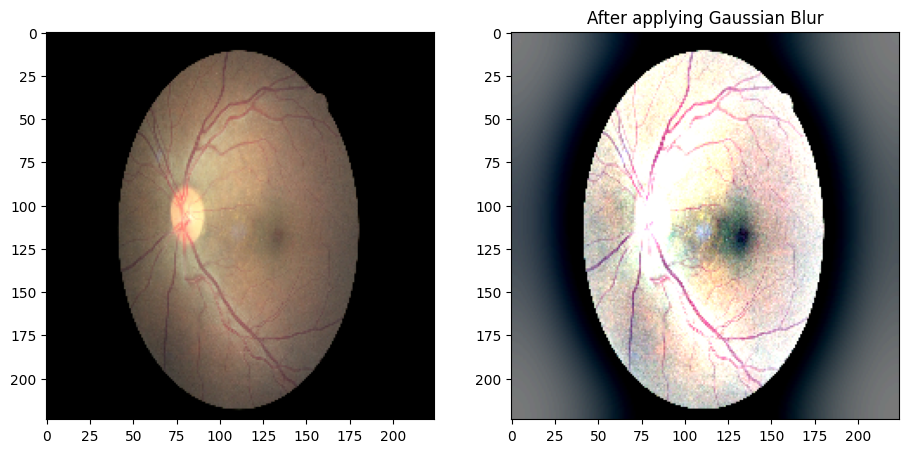

In [ ]:

img = cv2.imread('/content/colored_images/colored_images/No_DR/10003_left.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_t = cv2.addWeighted(img,4, cv2.GaussianBlur(img , (0,0) , 30) ,-4 ,128)

f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(img)
axarr[1].imshow(img_t)
plt.title('After applying Gaussian Blur')
plt.show()

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [ ]:
ex1= circle_crop(cv2.imread('/content/colored_images/colored_images/Proliferate_DR/10017_left.png'), 15)

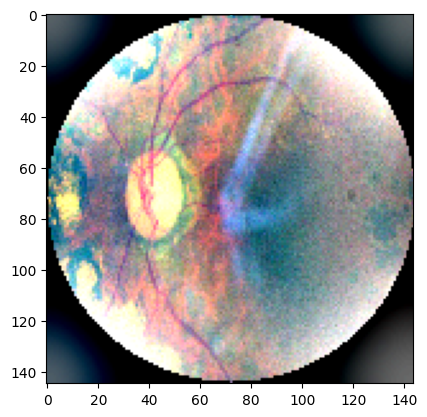

In [ ]:
plt.imshow(ex1, cmap=None)
plt.show()

In [ ]:
import glob

Mild = glob.glob('/content/new_filtered_image/Mild/*.*')
Moderate = glob.glob('/content/new_filtered_image/Moderate/*.*')
No_DR = glob.glob('/content/new_filtered_image/NO_DR/*.*')
Proliferate_DR = glob.glob('/content/new_filtered_image/Proliferate_DR/*.*')
Severe = glob.glob('/content/new_filtered_image/Severe/*.*')


data = []
labels = []

for i in No_DR:
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
    target_size= (100,100))
    image=np.array(image)
    data.append(image)
    labels.append(0)
for i in Moderate:
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
    target_size= (100,100))
    image=np.array(image)
    data.append(image)
    labels.append(1)
for i in Mild:
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
    target_size= (100,100))
    image=np.array(image)
    data.append(image)
    labels.append(2)
for i in Severe:
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
    target_size= (100,100))
    image=np.array(image)
    data.append(image)
    labels.append(3)
for i in Proliferate_DR:
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
    target_size= (100,100))
    image=np.array(image)
    data.append(image)
    labels.append(4)

data = np.array(data)
labels = np.array(labels)

from sklearn.model_selection import train_test_split
X_train, X_test, ytrain, ytest = train_test_split(data, labels, test_size=0.2,
                                                random_state=42)

In [ ]:
for patient in patients:
  label = traindf1._get_value(patient, 'level')
  path = data_dir + patient
  #try:
  slices = cv2.imread(path)
  gray_img = cv2.cvtColor(slices, cv2.COLOR_BGR2GRAY)
  binary_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY_INV, 131, 15)
  #img = cv2.imread(binary_img)
  input_path = '/content/filtered_image/'
  cv2.imwrite(input_path + patient, binary_img)


NameError: name 'patients' is not defined

In [ ]:
def dispersy(img):
    img_avg = cv2.mean(img)[0]
    img_avg_bright = img - img_avg
    fin_img = img_avg_bright/np.var(img,ddof=1)
    return fin_img



In [ ]:
#import glob
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)
train_generator = datagen.flow_from_dataframe(
dataframe=traindf,
directory= "../content/new_filtered_image/",
x_col="image",
y_col="level",
subset="training",
color_mode = "grayscale",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(100,100))

validation_generator = datagen.flow_from_dataframe(
dataframe=traindf,
directory= "../content/new_filtered_image/",
x_col="image",
y_col="level",
subset="validation",
color_mode = "grayscale",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(100,100))

Found 0 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 35126 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


Found 0 validated image filenames.


In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Set input shape
sample_shape = X_train[0].shape
img_width, img_height = sample_shape[0], sample_shape[1]
input_shape = (img_width, img_height, 1)

# Reshape data
# X_train = X_train.reshape(len(X_train), input_shape[0], input_shape[1], input_shape[2])
# X_test  = X_test.reshape(len(X_test), input_shape[0], input_shape[1], input_shape[2])

In [ ]:
model.fit(X_train, ytrain, batch_size=32, epochs=10, validation_data=(X_test, ytest))

Epoch 1/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 1209s 1s/step - accuracy: 0.7178 - loss: 2.9151 - val_accuracy: 0.7327 - val_loss: 0.8666
Epoch 2/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 1218s 1s/step - accuracy: 0.7388 - loss: 0.8713 - val_accuracy: 0.7327 - val_loss: 0.8997
Epoch 3/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 1205s 1s/step - accuracy: 0.7364 - loss: 0.8680 - val_accuracy: 0.7327 - val_loss: 0.8604
Epoch 4/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 1268s 1s/step - accuracy: 0.7366 - loss: 0.8583 - val_accuracy: 0.7326 - val_loss: 0.8597
Epoch 5/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 1277s 1s/step - accuracy: 0.7390 - loss: 0.8487 - val_accuracy: 0.7327 - val_loss: 0.8597
Epoch 6/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 1261s 1s/step - accuracy: 0.7298 - loss: 0.8702 - val_accuracy: 0.7326 - val_loss: 0.8553
Epoch 7/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 1223s 1s/step - accuracy: 0.7336 - loss: 0.8555 - val_accuracy: 0.7327 - val_loss: 0.8657
Epoch 8/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 1231s 1s/step - accuracy: 0.7354 - loss: 0.8522 - 

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 96, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 46, 46, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 21, 21, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 28224)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,806,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,872,293 (7.14 MB)

 Trainable params: 1,872,293 (7.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras

In [ ]:
# training the model for 10 epochs
model.fit(
    train_generator,
    batch_size=128,
    epochs=10,
    validation_data=(validation_generator))#change epoch to 9 later as long as the optimal results on 9

In [ ]:
mask = []
img = []
for filename in lst:
   if filename.endswith('.png'):
     img.append(filename)
     mask.append(filename)

img.sort()
mask.sort()
img = img[:1000]
masks = mask[:1000]

In [ ]:
for file in mask:
  index = img.index(file)
print(file)

9942_left.png


In [ ]:
y = np.zeros((1000, 28,28), dtype=np.float32)
X = np.zeros((1000,224, 224, 1), dtype=np.float32)
n = 0
for file in img:
  index = img.index(file)
  dir_img = os.path.join('/content/new_filtered_image/Proliferate_DR', file)
  img = Image.open(dir_img)
  img = img.resize((224, 224))
  img = np.reshape(img.convert('L'), (224,224,1))
  X[n] = img
  mask = masks[index]
  dir_mask = os.path.join('/content/new_filtered_image/Proliferate_DR', mask)
  mask_img = cv2.imread(dir_mask)
  mask_img = (mask!=2)*1.0
  mask_img = cv2.resize(mask, (28, 28))
  mask_img = 1.0*(mask[:,:,0]>0.2)
  y[n] = mask
  n += 1

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

In [ ]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from keras.models import model_from_json

from keras.layers import Input, Conv2D, Reshape
from keras.models import Model

In [ ]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)
# X_train, X_test, ytrain, ytest

In [ ]:
from keras.layers import Reshape
N = X_train.shape[-1]
base_model = Unet(backbone_name='resnet34',weights=None, encoder_weights='imagenet')
input_base_model = Input(shape=(224, 224, N))
l1 = Conv2D(3, (1, 1))(inp)
out = base_model(l1)
x1 = Conv2D(10, kernel_size=3, strides=2, padding="same", activation="relu")(out)
x1 = layers.BatchNormalization()(x1)
x2 = Conv2D(10, kernel_size=3, strides=2, padding="same", activation="relu")(x1)
x2 = layers.BatchNormalization()(x2)
x3 = Conv2D(10, kernel_size=3,strides=2,padding = "same", activation="relu")(x2)
x3 =layers.BatchNormalization()(x3)
x4 = Conv2D(1, kernel_size=2,strides=2,padding = "same", activation="relu")(x3)
x_out = Reshape((28,28))(x4)
model = Model(input_base_model, x_out, name=base_model.name)

In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

return numerator / (denominator + tf.keras.backend.epsilon())

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

model.compile(optimizer='sgd', loss=loss, metrics=[dice_coefficient])

model.fit(X_train,y_train,batch_size=32,epochs=30,validation_data=(X_test, y_test))


In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
from keras.models import model_from_json
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
def prediction(X, y, pred, k=None):
    if k is None:
        k = np.random.randint(0, len(X))

    has_mask = y[k].max() > 0

    figure, j = plt.subplots(1, 3, figsize=(20, 20))
    j[0].imshow(X[k])
    if has_mask:
        j[0].contour(y[k].squeeze())
    j[1].imshow(y[k].squeeze())
    j[2].imshow(pred[k].squeeze())
    if has_mask:
        j[2].contour(pred[k].squeeze())

prediction(X_train, y_train, model.predict(X_train))